# Olá,

Nesse tutorial, vamos botar em prática o que foi visto nessa breve introdução de LSTM. Você poderá aprender como implementar uma LSTM para o dataset seguindo este notebook. Tentarei explicar tudo em detalhes sobre a implementação deste notbook. Aproveite.

# Requisitos

In [ ]:
!pip install numpy
!pip install pandas
!pip install keras
!pip install theano
!pip install sklearn
!pip install np_utils
!pip install tensorflow
!pip install seaborn

# Dataset

Para este problema nos iremos tentar resolver um problema de predição de problemas relacionados a passagens aéreas. Neste dataset, encontraremos uma serie temporal onde para um dado mês do ano, a tarefa é predizer o número de problemas com passagens aérias em unidades de milhares. Os dados variam de Janeiro/1949 a Dezembro/1960 (12 anos), com 144 observações.

In [2]:
import pandas

url = 'https://raw.githubusercontent.com/jinfagang/LSTM_learn/master/international-airline-passengers.csv'

dataset = pandas.read_csv(url,header=0,usecols=[1])

Segue uma pequena visualização dos dados iniciais.

In [3]:
dataset.head(5)

,passengers
0,112
1,118
2,132
3,129
4,121


Segue uma visualização da serie temporal do dataset.

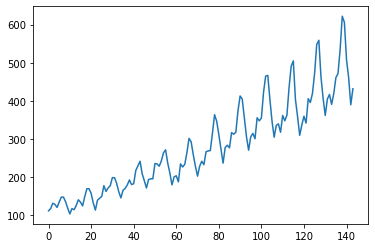

In [4]:
import matplotlib.pyplot as plt

plt.plot(dataset)
plt.show()

In [5]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Inicialmente convertemos o nosso dataset em um array de uma dimensão.

In [6]:
dataset = dataset.values
dataset = dataset.astype('float32')

dataset[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

# Normalização

Afim de uma melhor aprendizado da rede, realizaremos uma normalização nos dados. Podemos utilizar a classe MinMaxScaler para esta tarefa, onde a mesma consistem em modificar a escala do dados para um intervalo desejado (o até um número especificado). Logo para o nosso exemplo utilizaremos a escala de 0 até 1.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

# Separação dos dados

Separando manualmente o dataset, escolheremos 2/3 para o conjunto de test e 1/3 para o conjunto de treinamento.

In [8]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


# Criação do dataset

Agora nós podemos definir a função de criação do dataset apropriado para redes LSTM. Essa função consiste de dois argumentos, o dataset e uma valor de look back (valor responsável por definir quantos elementos serãm usador para previsão). Por padrão definimos look back = 1. Logo para todo tempo t+1 tentaremos predizzer o mesmo somente com 1 valor t.

Exemplo : Para a série : 112, 118, 132, 129, 121, 135 com lookback = 1, temos:

| t   | t+1 |
|-----|-----|
| 112 | 118 |
| 118 | 132 |
| 132 | 129 |
| 129 | 121 |
| 121 | 135 |

Já para mesma série com look back = 2, temos :

| t-1 | t   | t+1 |
|-----|-----|-----|
| 112 | 118 | 132 |
| 118 | 132 | 129 |
| 132 | 129 | 121 |
| 129 | 121 | 135 |

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 - 1s - loss: 0.0443
Epoch 2/100
 - 0s - loss: 0.0240
Epoch 3/100
 - 0s - loss: 0.0169
Epoch 4/100
 - 0s - loss: 0.0149
Epoch 5/100
 - 0s - loss: 0.0143
Epoch 6/100
 - 0s - loss: 0.0134
Epoch 7/100
 - 0s - loss: 0.0128
Epoch 8/100
 - 0s - loss: 0.0120
Epoch 9/100
 - 0s - loss: 0.0112
Epoch 10/100
 - 0s - loss: 0.0103
Epoch 11/100
 - 0s - loss: 0.0095
Epoch 12/100
 - 0s - loss: 0.0087
Epoch 13/100
 - 0s - loss: 0.0078
Epoch 14/100
 - 0s - loss: 0.0070
Epoch 15/100
 - 0s - loss: 0.0062
Epoch 16/100

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverte predição

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcula Erro quadrado médio

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.26 RMSE
Test Score: 47.05 RMSE


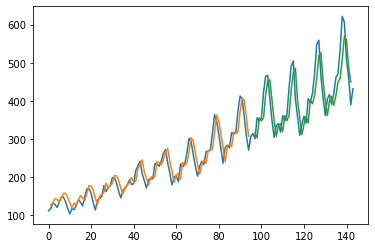

In [14]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predição de test

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# IMDb

IMDb, também conhecida como Internet Movie Database, (Em Português: Base de Dados de Filmes na Internet) é uma base de dados online de informação sobre música, cinema, filmes, programas e comerciais para televisão e jogos de computador, hoje pertencente à Amazon. Com isso, usaremos o dataset do keras para classificar, qual o sentimento de uma pessoa (bom ou ruim) em relação a um comentário.

In [15]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


numpy.random.seed(7)


top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

17465344/17464789 [==============================] - 15s 1us/step


# Pad

Depois de carregar o dataset, nós precisamos normalizar o número de palavras em uma comentário, afim de que todos os cometários possuam o mesmo tamanho para modelagem. O modelo ira aprender que valores que possuem 0 não devem influênciar em sua predição (pois não adicionam nenhuma informação).

Exemplo :

Modelo possuindo sempre 5 entrada temos :

    (1,2,3,4,5) => (1,2,3,4,5)
    (1,2,5) => (1,2,5,0,0)
    (1) => (1,0,0,0,0)

In [16]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# Embedding vetor

Agora podemos definir, compilar e ajustar nosso modelo LSTM. A primeira camada é a camada Embedded que usa 32 vetores de comprimento para representar cada palavra. A próxima camada é a camada LSTM com 100 neurônios. Finalmente, porque este é um problema de classificação, usamos uma camada Dense camada de saída com um único neurônio e uma função de ativação sigmóide para fazer previsões 0 ou 1 para as duas classes (boas e ruins) no problema. Como é um problema de classificação binária, a função de loss é usada como a função binary-crossentropy.

In [17]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

# Avaliação final
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/srv/conda/envs/notebook/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
25000/25000 [==============================] - 731s 29ms/step - loss: 0.5417 - accuracy: 0.7371
Epoch 2/3
25000/25000 [==============================] - 691s 28ms/step - loss: 0.4893 - accuracy: 0.7806
Epoch 3/3
25000/25000 [==============================] - 167s 7ms/step
Accuracy: 77.85%
